<center>
    <h1> Background Substitution with Median Filtering Algorithm</h1>
    <h3> CSRG </h3>
</center>

In [11]:
import numpy as np
import scipy as sp
import scipy.ndimage as spndim
import matplotlib.pyplot as plt
from ipywidgets import widgets, interact_manual
from PIL import Image 

<h3> Índice </h3>

* [1.- Median Filtering Implementation](#item5)
* [2.- Testing with FITS Image](#item6)
* [3.- Background Estimation](#item7)

<div id='item5' />
<h3> Median Filtering Implementation </h3>

In [5]:
import statistics as st
import math

def median_filter(array_image, window):
    if (len(array_image.shape) != 2):
        print("Please, enter a 2D array")
        return
    # Median_filter only works for odd window sizes bigger than 1.
    if (window%2 == 0):
        print("Please, enter an odd window number")
        return
    if (window == 1):
        return array_image
    # Array to return, has the same size as the original array.
    array = array_image.copy()
    # Roam rows
    for i in range(array.shape[0]):
        # If it gets to the bottom, stops. 
        if (i+window > array.shape[0]):
            return array
        # Roam columns
        for j in range(array.shape[1]):
            # If it gets to the right end of the matrix, continues with next row.
            if (j+window > array.shape[1]):
                break
            # Creates a submatrix with size indicated by window.
            subarray = array[i:i+window,j:j+window]
            # Calculates median of that submatrix
            median = st.median(subarray.ravel())
            # Calculates submatrix midpoint.
            factor = math.floor(window/2)
            # Replace midpoint element with resulting median. 
            array[i+factor,j+factor] = median

Advice: The execution of this function applied to big images, could be slower. It's recommendable to use scipy.signal.medfilt or scipy.ndimage.median_filter functions instead.

<div id='item6' />
<h3> Testing with FITS Image </h3>

In [9]:
from astropy.utils.data import download_file
from astropy.io import fits
from scipy.signal import medfilt

In [12]:
%matplotlib inline

image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits', cache=True )
image_data = fits.getdata(image_file)

def widgpy(n):
    image_med = medfilt(image_data, n)
    # Plot
    plt.figure(figsize=(26, 10))
    # Noisy Image
    plt.subplot(142)
    plt.imshow(image_data)
    plt.axis('off')
    plt.title('Noisy image', fontsize=20)
    # Median Filtered Image
    plt.subplot(143)
    plt.imshow(image_med)
    plt.axis('off')
    plt.title('Median filter with Window Size='+str(n), fontsize=20)
    plt.subplot(144)
    plt.imshow(np.abs(image_data - image_med))
    plt.axis('off')
    plt.title('Error', fontsize=20)
    plt.show()
    
interact_manual(widgpy,n=widgets.IntSlider(min=1,max=13,step=1,value=1))

interactive(children=(IntSlider(value=1, description='n', max=13, min=1), Button(description='Run Interact', s…

<function __main__.widgpy(n)>

<div id='item7' />
<h3> Background Estimation </h3>

In [13]:
# Creating images array with filtered medians

def mfarray(im, wmin, wmax):
    arr = []
    for i in range(wmin, wmax+1):
        if (i%2==0):
            continue
        mft = median_filter(im, i)    
        arr.append(mft)
    return np.asarray(arr)

In [14]:
# Background Estimation

def back_est(im, wmin, wmax):
    # Primera estimación
    aux = mfarray(im, wmin, wmax)
    est_back1 = np.min(aux, axis=0)
    # Segunda estimación
    aux = np.array([est_back1, spndim.median_filter(est_back1, wmax)])
    est_back2 = np.min(aux, axis=0)
    return est_back2

# Background Estimation Improvement

def imp_backest(im, wmin, wmax, n):
    S = np.copy(im)
    B = np.zeros_like(im)
    for i in range(n):
        b = back_est(S, wmin, wmax)
        S = S - b
        B = B + b
    return S, B        

Example for first Background Estimation version

In [15]:
from astropy.io import fits

image_file = download_file('https://astropy.stsci.edu/data/tutorials/FITS-images/M13_blue_0002.fits', cache=True )
image_data = fits.getdata(image_file, ext=0)

Text(0.5,1,'Estimated Background')

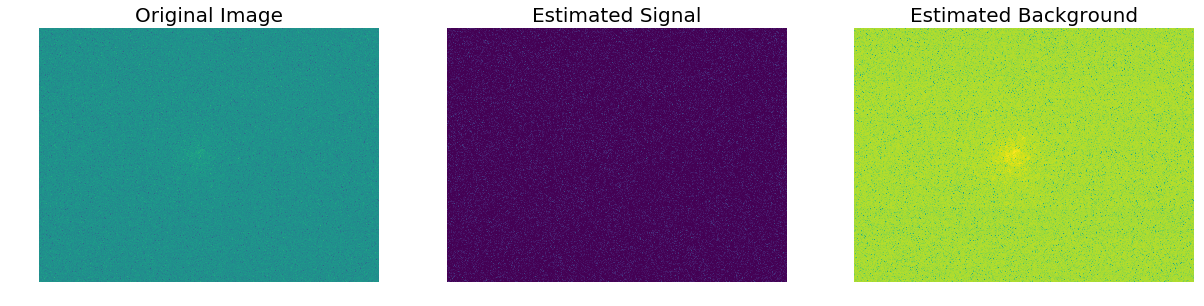

In [16]:
signal, bg = imp_backest(image_data, 1, 5, 3)

plt.figure(figsize=(28, 12))
# Original image
plt.subplot(141)
plt.imshow(image_data)
plt.axis('off')
plt.title('Original Image', fontsize=20)
# Estimated Sinal
plt.subplot(142)
plt.imshow(signal)
plt.axis('off')
plt.title('Estimated Signal', fontsize=20)
# Estimated Background
plt.subplot(143)
plt.imshow(bg)
plt.axis('off')
plt.title('Estimated Background', fontsize=20)